In [1]:
import torch
import tensorflow
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
from skimage.metrics import structural_similarity as ssim
import numpy as np
from noggin import create_plot
import os
import skimage
import cv2
import tensorflow as tf

In [2]:
def normalize(path):
    for file in os.listdir(path):
        img = cv2.imread(path + '/' + file)
        img = cv2.normalize(img, None, alpha=0,beta=200, norm_type=cv2.NORM_MINMAX)
        
normalize('imgs/')
        

In [3]:
def interpolation(path, factor):
    for file in os.listdir(path):
        img = cv2.imread(path + '/' + file)
        h, w, c = img.shape
        new_height = int(h / factor)
        new_width = int(w / factor)
        
        # resize the image - down
        img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR) #interploation are methods for resizing images;how do you go from image with 100px to 1000px 
        #bilinear interpolation
        
        # resize the image - up
        img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
        
        print('Saving {}'.format(file))
        cv2.imwrite('bad/{}'.format(file), img)

interpolation("imgs/", 3)

Saving jw-image-1.jpg
Saving jw-image-2.jpg
Saving jw-image-3.jpg
Saving jw-image-4.jpg


In [6]:
def mse(target,ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err=np.sum((target.astype('float')-ref.astype('float'))**2)
    err=err/float(target.shape[0]*target.shape[1])#divided by total number of pixels
    
    return err

#     target_data = np.array(target, dtype=float)
#     ref_data = np.array(ref, dtype=float)

#     diff = ref_data - target_data
#     diff = diff.flatten('C')

#     rmse = np.sqrt(np.mean(diff ** 2.))

#     return 20 * np.log10(255. / rmse)

In [7]:
for file in os.listdir('bad/'):
    
    #open target and reference images
    target=cv2.imread('bad/{}'.format(file))
    ref = cv2.imread('imgs/{}'.format(file))
    
    #calculate scores
    score = mse(target, ref)
    
    print('{}\nMSE: {}\n'.format(file, score))

jw-image-1.jpg
MSE: 377.30517054056463

jw-image-2.jpg
MSE: 125.78888088273251

jw-image-3.jpg
MSE: 220.87953881527062

jw-image-4.jpg
MSE: 153.04048387504105



In [8]:
def super_res():
    SRCNN = Sequential()
        
    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))#only if in keras.json image_data_format is channels_last; else if channels_first then 1,None,None
        
    SRCNN.add(Conv2D(filters=64, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                         activation='relu', padding='same', use_bias=True))
        
    SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                         activation='linear', padding='valid', use_bias=True))
        
    SRCNN.compile(optimizer=Adam(lr=0.0003), loss=tf.keras.losses.MeanSquaredError(), metrics=['mean_squared_error'])
    
    return SRCNN

In [9]:
def modcrop(img,scale):
    #temp size
    tmpsz=img.shape
    sz=tmpsz[0:2]
    
    #ensures that dimension of our image are divisible by scale(doesn't leaves hanging remainders) by cropping the images size
    #np.mod returns the remainder bewtween our sz and scale
    sz=sz-np.mod(sz,scale)
    
    img=img[0:sz[0],1:sz[1]]
    return img

#crop offs the bordersize from all sides of the image
def shave(image,border):
    img=image[border: -border,border:-border]
    return img

In [10]:
test = cv2.imread('bad/jw-image-1.jpg')

print(np.min(test))
print(np.max(test))

0
255


In [29]:
#define main prediction function
srcnn=super_res()
def predict(image_path):
#     names = os.listdir(image_path)
#     names = sorted(names)
#     nums = names.__len__()
    srcnn.load_weights(r"C:\Users\tanay\CogWorks\SRCNN-keras\SRCNN_check.h5")
#     name = image_path + names[i]
#     hr_img = cv2.imread(name, cv2.IMREAD_COLOR)
#     hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
#     hr_img = hr_img[:, :, 0]
#     shape = hr_img.shape
#      # two resize operation to produce training data and labels
#     lr_img = cv2.resize(hr_img, (int(shape[1] / scale), int(570 / 2)))
#     lr_img = cv2.resize(lr_img, (shape[1], shape[0]))
    #load the srcnn model with weights cuz deep learning neural n/w take lot of time to train(have to feed in large amount of input data)
#     
     
#     load the degraded and reference images
#     in opencv, images are loaded as BGR channels
    path,file=os.path.split(image_path)
    degraded=cv2.imread(image_path)
    ref=cv2.imread('imgs/{}'.format(file))

    #preprocess the image with modcrop
    ref=modcrop(ref,3)#when calculating our image quality metrics later we have the same size image to what we produce in SRCNN network
    degraded=modcrop(degraded,3)
    
    #convert the image to YCrCb(3 channel image) - (srcnn trained on Y channel)
    temp=cv2.cvtColor(degraded,cv2.COLOR_BGR2YCrCb)
    #opencv does a very good job in converting from rgb to YCrCb and back
    
    #create image slice and normalize cuz SRCNN works on one dimensional input(or 3D inputs of depth 1 ,ie, inputs with one channel)
    Y=np.zeros((1,temp.shape[0],temp.shape[1],1),dtype=float)
    #create a numpy array the we fill with data,temp.shape[0]=width,[1]=height and last one means one channel(essentially like batch=1 cuz that's what going to get passed to the n/w ')
    #fill in the data; all values are normalized to between 0 and 1 as that's how srcnn was trained
    Y[0,:,:,0]=temp[:,:,0].astype(float)/255
    #first 0 means 0th index(we are saying that batch size is 1); :,: means every point in these channels; last 0 means first channel,ie, all the pixels in first luminescence channel
    #so we have our image slice, we have the Y channel, which is the first channel(index 0) out of the image that we converted to YCrCb color space
    
    #perform super-resolution with srcnn
    pre=srcnn.predict(Y,batch_size=1)#that's why we had index 0  above cuz we are saying that batch size is 1
    
    #post-process output cuz pre is still normalized
    pre*=255#multiplying every pixel by 255
    pre[pre[:]>255]=255#any pixels >255 set it =255 to prevent any rounding errors due to multiplication
    pre[pre[:]<0] =0# same reason as above
    pre=pre.astype(np.uint8)#convert float back to int values
    
    #cuz this is only the luminescence channel in the pre ,SO
    #copy Y channel back to image and convert to BGR
    temp=shave(temp,6)#accd.to tutor it loses 3 pixels on each side so if we shave this with a border 6,we can crop it appropriately there, so it is the same size as our output
    #if not agree with tutor, use print statements to see the specific dimensions
    
    # for the first channel(Y channel), copy in the output of our network
    temp[:,:,0]=pre[0,:,:,0]
    #So we are keeping the red difference and blue difference, channels 1 and 2, in this temp image which is in the YCrCb color space
    #and in the first one we are copying in our ouput,our luminiscence channel
    
    #convert back to bgr
    output=cv2.cvtColor(temp,cv2.COLOR_YCrCb2BGR)
    
    #emove borderfrom reference and degraded image, so that all our images(ref,degraded(low res.), and ouput(high res.)) are of the same size
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    
    # image quality calculations
    scores = []
    scores.append(mse(degraded, ref))#degraded wrt ref
    scores.append(mse(output, ref))#high res. output wrt ref
    
    # return images and scores
    return ref, degraded, output, scores

In [12]:
def transform_images(directory, output_directory, scaling_factor=2, max_nb_images=-1, true_upscale=False):
    index = 1

    if not os.path.exists(output_directory + "X/"):
        os.makedirs(output_directory + "X/")

    if not os.path.exists(output_directory + "y/"):
        os.makedirs(output_directory + "y/")

    # For each image in input_images directory
    nb_images = len([name for name in os.listdir(directory)])

    if max_nb_images != -1:
        print("Transforming %d images." % max_nb_images)
    else:
        assert max_nb_images <= nb_images, "Max number of images must be less than number of images in path"
        print("Transforming %d images." % (nb_images))

    if nb_images == 0:
        print("Extract the training images or images from imageset_91.zip (found in the releases of the project) "
              "into a directory with the name 'input_images'")
        print("Extract the validation images or images from set5_validation.zip (found in the releases of the project) "
              "into a directory with the name 'val_images'")
        exit()

    for file in os.listdir(directory):
        img = imread(directory + file, mode='RGB')

        # Resize to 256 x 256
        img = imresize(img, (img_size, img_size))

        # Create patches
        hr_patch_size = (16 * scaling_factor * _image_scale_multiplier)
        nb_hr_images = (img_size ** 2) // (stride ** 2)

        hr_samples = np.empty((nb_hr_images, hr_patch_size, hr_patch_size, 3))

        image_subsample_iterator = subimage_generator(img, stride, hr_patch_size, nb_hr_images)

        stride_range = np.sqrt(nb_hr_images).astype(int)

        i = 0
        for j in range(stride_range):
            for k in range(stride_range):
                hr_samples[i, :, :, :] = next(image_subsample_iterator)
                i += 1

        lr_patch_size = 16 * _image_scale_multiplier

        t1 = time.time()
        # Create nb_hr_images 'X' and 'Y' sub-images of size hr_patch_size for each patch
        for i in range(nb_hr_images):
            ip = hr_samples[i]
            # Save ground truth image X
            imsave(output_directory + "/y/" + "%d_%d.png" % (index, i + 1), ip)

            # Apply Gaussian Blur to Y
            op = gaussian_filter(ip, sigma=0.5)

            # Subsample by scaling factor to Y
            op = imresize(op, (lr_patch_size, lr_patch_size), interp='bicubic')

            if not true_upscale:
                # Upscale by scaling factor to Y
                op = imresize(op, (hr_patch_size, hr_patch_size), interp='bicubic')

            # Save Y
            imsave(output_directory + "/X/" + "%d_%d.png" % (index, i+1), op)

        print("Finished image %d in time %0.2f seconds. (%s)" % (index, time.time() - t1, file))
        index += 1

        if max_nb_images > 0 and index >= max_nb_images:
            print("Transformed maximum number of images. ")
            break

    print("Images transformed. Saved at directory : %s" % (output_directory))

In [13]:
BLOCK_STEP = 16
BLOCK_SIZE = 32
Random_Crop = 30
Patch_size = 32
label_size = 20
conv_side = 6
scale = 2

def prepare_data(_path):
    names = os.listdir(_path)
    names = sorted(names)
    nums = names.__len__()

    data = np.zeros((nums * Random_Crop, 1, Patch_size, Patch_size), dtype=np.double)
    label = np.zeros((nums * Random_Crop, 1, label_size, label_size), dtype=np.double)

    for i in range(nums):
        name = _path + names[i]
        hr_img = cv2.imread(name, cv2.IMREAD_COLOR)
        shape = hr_img.shape

        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
        hr_img = hr_img[:, :, 0]

        # two resize operation to produce training data and labels
        lr_img = cv2.resize(hr_img, (int(shape[1] / scale), int(shape[0] / scale)))
        lr_img = cv2.resize(lr_img, (shape[1], shape[0]))

        # produce Random_Crop random coordinate to crop training img
        Points_x = np.random.randint(0, min(shape[0], shape[1]) - Patch_size, Random_Crop)
        Points_y = np.random.randint(0, min(shape[0], shape[1]) - Patch_size, Random_Crop)

        for j in range(Random_Crop):
            lr_patch = lr_img[Points_x[j]: Points_x[j] + Patch_size, Points_y[j]: Points_y[j] + Patch_size]
            hr_patch = hr_img[Points_x[j]: Points_x[j] + Patch_size, Points_y[j]: Points_y[j] + Patch_size]

            lr_patch = lr_patch.astype(float) / 255.
            hr_patch = hr_patch.astype(float) / 255.

            data[i * Random_Crop + j, 0, :, :] = lr_patch
            label[i * Random_Crop + j, 0, :, :] = hr_patch[conv_side: -conv_side, conv_side: -conv_side]
            # cv2.imshow("lr", lr_patch)
            # cv2.imshow("hr", hr_patch)
            # cv2.waitKey(0)
    return data, label

def prepare_crop_data(_path):
    names = os.listdir(_path)
    names = sorted(names)
    nums = names.__len__()

    data = []
    label = []

    for i in range(nums):
        name = _path + names[i]
        hr_img = cv2.imread(name, cv2.IMREAD_COLOR)
        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
        hr_img = hr_img[:, :, 0]
        shape = hr_img.shape
        print(shape)

        # two resize operation to produce training data and labels
        lr_img = cv2.resize(hr_img, (int(shape[1] / scale), int(570 / 2)))
        lr_img = cv2.resize(lr_img, (shape[1], shape[0]))

        width_num = int((shape[0] - (BLOCK_SIZE - BLOCK_STEP) * 2) / BLOCK_STEP)
        height_num = int((shape[1] - (BLOCK_SIZE - BLOCK_STEP) * 2) / BLOCK_STEP)
        for k in range(width_num):
            for j in range(height_num):
                x = k * BLOCK_STEP
                y = j * BLOCK_STEP
                hr_patch = hr_img[x: x + BLOCK_SIZE, y: y + BLOCK_SIZE]
                lr_patch = lr_img[x: x + BLOCK_SIZE, y: y + BLOCK_SIZE]

                lr_patch = lr_patch.astype(float) / 255.
                hr_patch = hr_patch.astype(float) / 255.

                lr = np.zeros((1, Patch_size, Patch_size), dtype=np.double)
                hr = np.zeros((1, label_size, label_size), dtype=np.double)

                lr[0, :, :] = lr_patch
                hr[0, :, :] = hr_patch[conv_side: -conv_side, conv_side: -conv_side]

                data.append(lr)
                label.append(hr)

    data = np.array(data, dtype=float)
    label = np.array(label, dtype=float)
    return data, label

In [14]:
from keras.callbacks import ModelCheckpoint
import h5py

def write_hdf5(data, labels, output_filename):
    """
    This function is used to save image data and its label(s) to hdf5 file.
    output_file.h5,contain data and label
    """

    x = data.astype(np.float32)
    y = labels.astype(np.float32)

    with h5py.File(output_filename, 'w') as h:
        h.create_dataset('data', data=x, shape=x.shape)
        h.create_dataset('label', data=y, shape=y.shape)
        # h.create_dataset()


def read_training_data(file):
    with h5py.File(file, 'r') as hf:
        data = np.array(hf.get('data'))
        label = np.array(hf.get('label'))
        train_data = np.transpose(data, (0, 2, 3, 1))
        train_label = np.transpose(label, (0, 2, 3, 1))
        return train_data, train_label
    
data, label = prepare_crop_data("source/")
write_hdf5(data, label, "crop_train.h5")
data, label = prepare_data("imgs/")
write_hdf5(data, label, "test.h5")

(480, 500)
(512, 512)
(576, 720)
(288, 288)
(256, 256)
(288, 352)
(361, 250)
(276, 276)
(362, 500)
(288, 352)
(280, 280)
(512, 512)
(512, 768)
(512, 512)
(656, 529)
(344, 228)
(391, 586)


In [15]:
from PIL import Image
im = Image.fromarray(output[:,:,::-1])
im.save("bad/jw-image.jpg")

NameError: name 'output' is not defined

In [16]:
data, label = read_training_data("./crop_train.h5")
val_data, val_label = read_training_data("./test.h5")

checkpoint = ModelCheckpoint("SRCNN_check.h5", monitor='val_loss', verbose=1, save_best_only=True,
                                 save_weights_only=False, mode='min')
callbacks_list = [checkpoint]

srcnn.fit(data, label, batch_size=28, validation_data=(val_data, val_label),
                    callbacks=callbacks_list, shuffle=True, epochs=3, verbose=0)



KeyboardInterrupt: 

In [17]:
import tensorflow as tf
mse2 = tf.keras.losses.MeanSquaredError()

1/1 [==============================] - 2s 2s/step
Degraded Image: 
MSE: 126.24098645670686

Reconstructed Image: 
MSE: 116.81172718514335

12.706578961939249


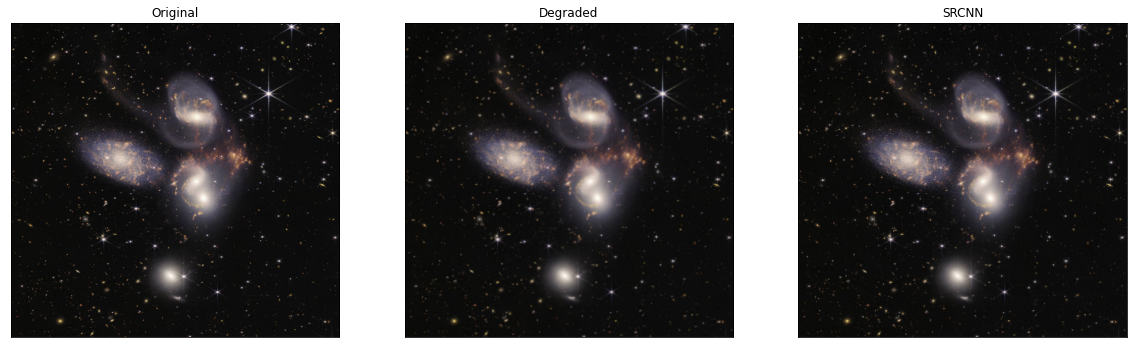

In [33]:
ref, degraded, output,scores= predict(r"C:\Users\tanay\CogWorks\Image-Restoration-using-SRCNN\bad\jw-image-2.jpg")
# print all scores for all images
print('Degraded Image: \nMSE: {}\n'.format(scores[0]))
print('Reconstructed Image: \nMSE: {}\n'.format(scores[1]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))#1 row,3 columns
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))#first subplot
#imshow assumes RGB images but cv2 loads images as BGR else channel mixing will take place and we will get weird images
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))#2nd subplot
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')

print(mse(degraded, output))

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])#leave them blank to remove ticks
    ax.set_yticks([])

In [ ]:
train_images = []
train_truth = []
for file in os.listdir('imgs/'):
    target=cv2.imread('bad/{}'.format(file))
    ref = cv2.imread('imgs/{}'.format(file))
    
    train_images.append(target)
    train_truth.append(ref)

print(train_images[0])
print(len(train_truth[3]))

In [ ]:
srcnn.fit(train_images[0],
                                 steps_per_epoch=1,
                                 epochs=3)
# for epoch in range(3):
#     loss = []
#     for file in os.listdir('bad/'):

#         # perform super-resolution
#         ref, degraded, output, scores = predict('bad/{}'.format(file))

#         # display images as subplots
#         fig, axs = plt.subplots(1, 3, figsize=(20, 8))
#         axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
#         axs[0].set_title('Original')
#         axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
#         axs[1].set_title('Degraded')
#         axs[1].set(xlabel = 'MSE: {}\n'.format(scores[0]))
#         axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
#         axs[2].set_title('SRCNN')
#         axs[2].set(xlabel = 'MSE: {}\n'.format(scores[1]))

#         # remove the x and y ticks
#         for ax in axs:
#             ax.set_xticks([])
#             ax.set_yticks([])
            
#         loss.append(scores[1])
        
#     np.array(loss)


      
#     print('Saving {}'.format(file))
#     fig.savefig('output/{}.png'.format(os.path.splitext(file)[0])) 
#     plt.close()